In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
pip -q install transformers

# remove the directory if necessary
# rm -rf "/content/gdrive/MyDrive/6864_hw4/"

mkdir "/content/drive/My Drive/NLP/"
cd "/content/drive/My Drive/NLP/"

mkdir: cannot create directory ‘/content/drive/My Drive/NLP/’: File exists


In [ ]:
import numpy as np
import pandas as pd
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
project_path = '/content/drive/My Drive/NLP/'
dataset = pd.read_csv(project_path + 'fake_and_real_news/combined.csv')
dataset['text'] = dataset['text'].str.replace("^.*\(Reuters\) - ", "", regex=True)


In [ ]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer('hello world')

{'input_ids': [101, 7592, 2088, 102], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
import torch.nn as nn

class FakeNewsClassifier(nn.Module):
  def __init__(self, lm):
    super(FakeNewsClassifier, self).__init__()
    self.lm = lm
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask=None):
    lm_output = self.lm(input_ids, attention_mask)
    logits = lm_output.logits
    pred = self.sigmoid(logits)
    return pred
  


In [ ]:
#distilbert = transformers.AutoModel.from_pretrained('distilbert-base-uncased')
config = transformers.DistilBertConfig(num_labels=1)
distilbert = transformers.DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
model = FakeNewsClassifier(distilbert)
model = model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [ ]:
def tokenize_batch_farn(batch):
  x = list(batch['text'])
  y = np.array(batch['label'])
  
  x_encode = tokenizer.batch_encode_plus(
      x,
      max_length=512,
      truncation=True,
      padding='longest',
      return_attention_mask=True,
      return_tensors='pt'
  )
  input_ids = x_encode['input_ids'].cuda()
  input_mask = x_encode['attention_mask'].cuda()

  return input_ids, input_mask, y

In [ ]:

training_size = int(.6*dataset.shape[0])
validation_size = int(.2*dataset.shape[0])
testing_size = int(.2*dataset.shape[0])

data_train = dataset[:training_size]
data_val = dataset[training_size:training_size+validation_size]
data_test = dataset[training_size+validation_size:]

print(len(data_train))
print(data_train['label'].sum() / len(data_train))
print(len(data_val))
print(data_val['label'].sum() / len(data_val))
print(len(data_test))
print(data_test['label'].sum() / len(data_test))


26938
0.4803994357413319
8979
0.48234770018933065
8981
0.46152989644805703


In [ ]:
def decode(pred):
  decoded = torch.where(pred >= 0.5, 1, 0)
  return decoded

def get_acc(preds, labels):
  decoded = decode(preds).to(dtype=torch.float32)
  acc = torch.where(decoded == labels, 1, 0)
  return acc.sum()


Loss: 0.6657864451408386
Val acc: 0.5069606860452166
Loss: 0.01894293911755085
Val acc: 0.9908675799086758
Loss: 0.0051917326636612415
Val acc: 0.9963247577681257
Loss: 0.0027578987646847963
Val acc: 0.9950996770241675
Loss: 0.011213124729692936
Val acc: 0.9958792738612318
Loss: 0.18185503780841827
Val acc: 0.9909789508853992
Loss: 0.008813580498099327
Val acc: 0.9612429001002338
Loss: 0.004336565732955933
Val acc: 0.9971043546051899
Loss: 0.012679137289524078
Val acc: 0.9956565319077848
Loss: 0.0030964352190494537
Val acc: 0.9974384675353603
Loss: 0.002199543872848153
Val acc: 0.9964361287448491
Loss: 0.0009630044223740697
Val acc: 0.9950996770241675
Loss: 0.01611875183880329
Val acc: 0.9898652411181647
Loss: 0.03470291942358017
Val acc: 0.9969929836284664


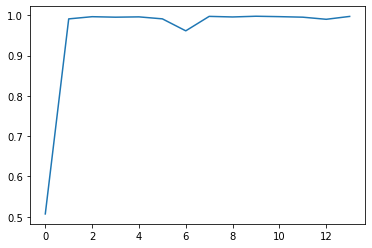

In [ ]:

import matplotlib.pyplot as plt

num_epochs = 1
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 16
warmup_rate = 0.05

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

loss_fn = nn.BCELoss()

model.train()

val_accuracies = []
for _ in range(num_epochs):
  for i in range(0, len(data_train), batch_size):
    batch = data_train[i : i + batch_size]
    input_ids, input_mask, labels = tokenize_batch_farn(batch)
    labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()

    model.zero_grad()
    predictions = model(input_ids, input_mask)
    predictions.to(torch.float32)

    loss = loss_fn(predictions, labels)
    loss.backward()

    ext_optim.step()

    if i % 1000 == 0:
      total_val_acc = 0
      val_batch_size = 16
      for i in range(0, len(data_val), val_batch_size):
        input_ids, input_mask, labels = tokenize_batch_farn(data_val[i : i+val_batch_size])
        labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()
        preds = model.forward(input_ids, input_mask)
        decoded = decode(preds).to(dtype=torch.float32)
        acc = get_acc(decoded, labels)
        total_val_acc += acc
      total_val_acc = int(total_val_acc) / len(data_val)
      val_accuracies.append(total_val_acc)

      print("Loss: {}".format(loss))
      print("Val acc: {}".format(total_val_acc))

plt.plot(val_accuracies)
plt.show()

torch.save(model.state_dict(), project_path+'distilbert/model_embed.pt')




In [ ]:
model.load_state_dict(torch.load(project_path + "distilbert/model_embed.pt"))

<All keys matched successfully>

In [ ]:
# def decode(pred):
#   decoded = torch.where(pred >= 0.5, 1, 0)
#   return decoded

test_sample = data_test


results = []
labels_ = []
total_acc = 0
test_batch_size = 1
for i in range(0, len(test_sample), test_batch_size):

  input_ids, input_mask, labels = tokenize_batch_farn(test_sample[i : i+test_batch_size])
  labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()

  preds = model.forward(input_ids, input_mask)
  decoded = decode(preds).to(dtype=torch.float32)

  results.append(decoded)
  labels_.append(labels)
  acc = torch.where(decoded == labels, 1, 0)
  total_acc += acc.sum()

print(int(total_acc) / len(test_sample))


0.9978844226700813


In [ ]:

results = results.cpu()

labels = torch.cat(labels_).cpu()

print(results.shape, labels.shape)
results = results.reshape(-1)
labels = labels.reshape(-1)
print(results.shape, labels.shape)

from sklearn.metrics import precision_score, recall_score, f1_score

# accuracy = (results == labels).sum() / len(labels)

prec = precision_score(labels, results)
recall = recall_score(labels, results)
f1 = f1_score(labels, results)

print(acc, prec, recall, f1)

# true_pos = torch.logical_and([results, labels])
# false_pos = torch.logical_and([results, torch.logical_not(labels)])
# false_neg = torch.logical_and([labels, torch.logical_not(results)])

# precision = true_pos.sum() / (true_pos.sum() + false_pos.sum())
# recall = true_pos.sum() / (true_pos.sum() + false_neg.sum())





torch.Size([8981, 1]) torch.Size([8981, 1])
torch.Size([8981]) torch.Size([8981])
tensor([[1]], device='cuda:0') 0.9966297544535387 0.9987937273823885 0.9977105675382576
